In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics as m
import numpy as np
import matplotlib.pyplot as plt 
from sentence_transformers import SentenceTransformer
from transformers import BertForSequenceClassification, BertTokenizer, AutoModel, TrainingArguments, Trainer
from transformers import RobertaForMaskedLM,RobertaTokenizer, pipeline

from datasets import Dataset
from wordcloud import WordCloud


df = pd.read_csv("df_pp_stem_lemm.csv")
df = df.drop('Unnamed: 0',axis=1)
df.shape

(3184, 12)

In [2]:
df.head(3)

,sentiment,okpd_2,name,number,fz,date,preproccessed_name,preproccessed_okpd_2,preproccessed_name_stem,preproccessed_okpd_2_stem,preproccessed_name_lemm,preproccessed_okpd_2_lemm
0,0,62.01.29.000: Оригиналы программного обеспечен...,Предоставление неисключительного права испол...,№0169300040423000063,44,04.09.2023,предоставление неисключительного права исполь...,оригиналы программного обеспечения прочие,предоставлен неисключительн прав использован а...,оригинал программн обеспечен проч,предоставление неисключительный право использо...,оригинал программный обеспечение прочий \n
1,0,62.02.20.190: Услуги консультативные в области...,Предоставление услуг по сопровождению програм...,№0162300011123000065,44,07.09.2023,предоставление услуг по сопровождению програм...,услуги консультативные в области компьютерных...,предоставлен услуг сопровожден программн компл...,услуг консультативн област компьютерн технолог...,предоставление услуга сопровождение программны...,услуга консультативный область компьютерный те...
2,0,62.01.29.000: Оригиналы программного обеспечен...,Программное средство антивирусной защиты,№0122100010223000021,44,18.09.2023,программное средство антивирусной защиты,оригиналы программного обеспечения прочие,программн средств антивирусн защит,оригинал программн обеспечен проч,программный средство антивирусный защита \n,оригинал программный обеспечение прочий \n


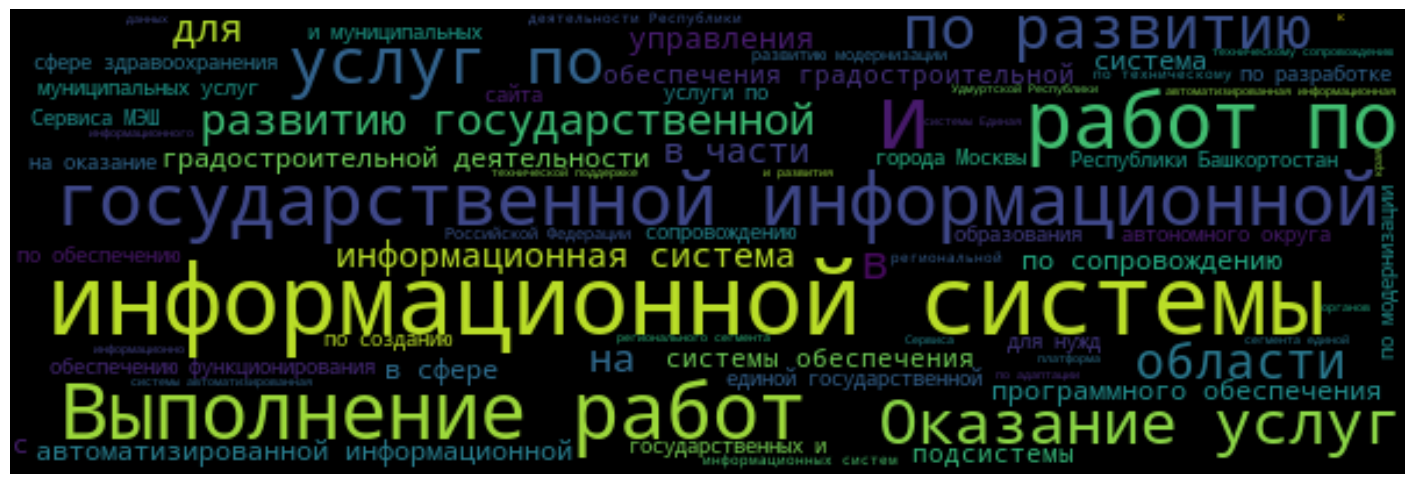

In [3]:
sarcastic = df[df['sentiment']==1]['name'].tolist()
genuine = df[df['sentiment']==0]['name'].tolist()
wordcloud = WordCloud(max_words=70, width=600, background_color='black').generate(" ".join(sarcastic))
plt.figure(figsize=(18,18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Axes: >

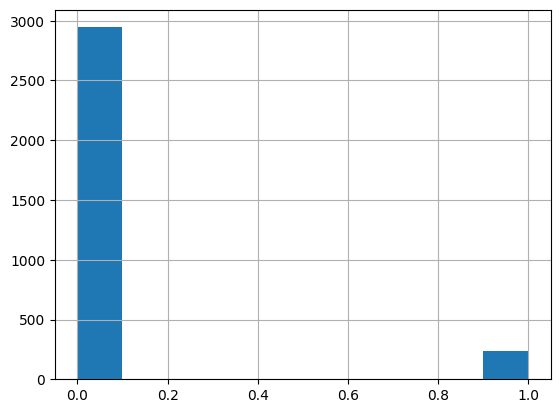

In [4]:
df['sentiment'].hist()

In [5]:
# ЗАГРУЗКА Модели
#кластеризация или семантический поиск.

#1024-мерное векторное пространство (1,71Gb)
st_sbertl = SentenceTransformer("Den4ikAI/sbert_large_mt_ru_retriever")

#768-мерное векторное пространство 
st_mpnet = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

#512-мерное векторное пространство
st_cased = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")

#384-мерное векторное пространство (471Мб)
st_L12 = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# получим эмбединги для колонки с текстом 
- колонка preproccessed_name - embedings)

In [6]:
df_col = df['name']

In [7]:
embedings_sbertl = st_sbertl.encode(df_col, show_progress_bar=True)

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
# embedings_mpnet = st_mpnet.encode(df_col, show_progress_bar=True)
# embedings_cased = st_cased.encode(df_col, show_progress_bar=True)
# embedings_L12 = st_L12.encode(df_col, show_progress_bar=True)

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Train - Validation - Test Splitting (80:10:10)

In [9]:
embedings = embedings_sbertl

label = df['sentiment'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(embedings, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

# Вывод размеров полученных датасетов
print("Размеры тренировочного датасета:", X_train.shape, y_train.shape)
print("Размеры тестового датасета:", X_test.shape, y_test.shape)
print("Размеры валидационного датасета:", X_val.shape, y_val.shape)

Размеры тренировочного датасета: (2547, 1024) (2547,)
Размеры тестового датасета: (319, 1024) (319,)
Размеры валидационного датасета: (318, 1024) (318,)


----------------

In [10]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42,
                           class_weight='balanced')

cb = CatBoostClassifier(random_seed=42, 
                        early_stopping_rounds=15,
                        auto_class_weights='Balanced',
                        depth=7,
                        n_estimators = 2000,
                        )

In [11]:
lr.fit(X_train, y_train)

c:\Users\Mi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

In [12]:
cb.fit(X_train, y_train, eval_set=(X_val, y_val))

Learning rate set to 0.029529
0:	learn: 0.6668407	test: 0.6771504	best: 0.6771504 (0)	total: 388ms	remaining: 12m 56s
1:	learn: 0.6452725	test: 0.6637361	best: 0.6637361 (1)	total: 591ms	remaining: 9m 50s
2:	learn: 0.6220334	test: 0.6469649	best: 0.6469649 (2)	total: 777ms	remaining: 8m 37s
3:	learn: 0.6015685	test: 0.6389924	best: 0.6389924 (3)	total: 941ms	remaining: 7m 49s
4:	learn: 0.5820690	test: 0.6267766	best: 0.6267766 (4)	total: 1.1s	remaining: 7m 18s
5:	learn: 0.5692820	test: 0.6224069	best: 0.6224069 (5)	total: 1.25s	remaining: 6m 56s
6:	learn: 0.5507967	test: 0.6174571	best: 0.6174571 (6)	total: 1.42s	remaining: 6m 44s
7:	learn: 0.5311810	test: 0.6026712	best: 0.6026712 (7)	total: 1.58s	remaining: 6m 34s
8:	learn: 0.5159518	test: 0.5942038	best: 0.5942038 (8)	total: 1.73s	remaining: 6m 23s
9:	learn: 0.4991450	test: 0.5891502	best: 0.5891502 (9)	total: 1.88s	remaining: 6m 14s
10:	learn: 0.4834624	test: 0.5815578	best: 0.5815578 (10)	total: 2.02s	remaining: 6m 6s
11:	learn: 0

-  LogisticRegression

In [13]:
print(m.classification_report(y_val, lr.predict(X_val)))
print("*"*100)
print(m.roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1]))
print("*"*100)
print((m.confusion_matrix(y_val, lr.predict(X_val))))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       294
           1       0.55      0.67      0.60        24

    accuracy                           0.93       318
   macro avg       0.76      0.81      0.78       318
weighted avg       0.94      0.93      0.94       318

****************************************************************************************************
0.9172335600907029
****************************************************************************************************
[[281  13]
 [  8  16]]


# LR
- на колонке preproccessed_name

               precision    recall   f1-score   support

           0       0.97      0.93      0.95       294
           1       0.45      0.71      0.55        24

    accuracy                           0.91       318
   macro avg       0.71      0.82      0.75       318
weighted avg       0.94      0.91      0.92       318

****************************************************************************************************
0.9458616780045352
****************************************************************************************************
[[273  21]
 [  7  17]]

- CatBoostClassifier

In [14]:
print(m.classification_report(y_val, cb.predict(X_val)))
print("*"*100)
print(m.roc_auc_score(y_val, cb.predict_proba(X_val)[:, 1]))
print("*"*100)
print((m.confusion_matrix(y_val, cb.predict(X_val))))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       294
           1       0.48      0.50      0.49        24

    accuracy                           0.92       318
   macro avg       0.72      0.73      0.72       318
weighted avg       0.92      0.92      0.92       318

****************************************************************************************************
0.9287131519274376
****************************************************************************************************
[[281  13]
 [ 12  12]]


____________________________________
_____________________________________

In [15]:
# 1.42 Gb
model = RobertaForMaskedLM.from_pretrained('sberbank-ai/ruRoberta-large', num_labels=df['sentiment'].nunique())

tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')

# unmasker = pipeline('fill-mask', model=model,tokenizer=tokenizer)
# unmasker("Стоит чаще писать на Хабр про <mask>.")


<Axes: >

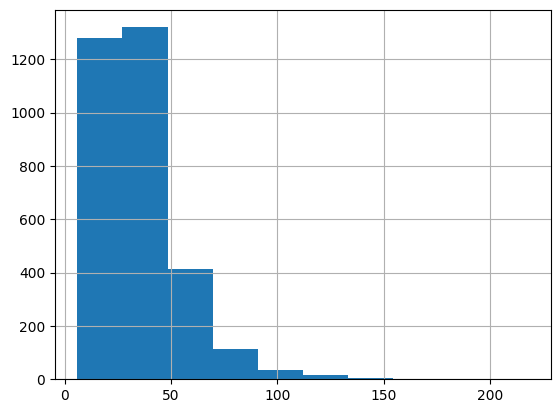

In [16]:
df['name'].apply(lambda x: len(tokenizer.encode(x))).hist()

In [17]:
data = Dataset.from_pandas(df)
data = data.train_test_split(test_size=0.2)

In [18]:
def tokenize_function(row):
    return tokenizer(row['name'], 
              truncation=True, 
              max_length=165, 
              padding='max_length')

In [19]:
train = data['train'].map(tokenize_function, batched=True)
test = data['test'].map(tokenize_function, batched=True)

train = train.rename_column("sentiment", "label")
test = test.rename_column("sentiment", "label")

Map:   0%|          | 0/2547 [00:00<?, ? examples/s]

Map:   0%|          | 0/637 [00:00<?, ? examples/s]

In [20]:
training_args = TrainingArguments(output_dir="temp",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=5,
                                  save_steps=200,
                                  per_device_eval_batch_size=64,
                                  per_device_train_batch_size=64,
                                  report_to='none')

In [21]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train,
                  eval_dataset={"TRAIN":train, "VALID":test},
                #   compute_metrics=ServiceCategorizer.compute_metrics,
                #   custom_class_weight=self.class_weights
                  )

In [22]:
trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 166.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 9.28 GiB is allocated by PyTorch, and 171.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
preds = trainer.predict(test)

In [ ]:
from torch.nn import Sigmoid
import torch

test_probas = torch.sigmoid(torch.from_numpy(preds.predictions[:, 1]))

test_labels = test_probas.numpy() > 0.5
test_labels = test_labels.tolist()

In [ ]:
print(m.classification_report(test['label'], test_labels))